In [1]:
import polars as pl
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import os 
import glob
import os
import gc
gc.collect()  # Manually free memory

from pathlib import Path
from scipy.stats import skew
from typing import List, Tuple, Dict
from sklearn.preprocessing import LabelEncoder

In [2]:
# Directory paths
ROOT_DIR = Path(os.getcwd())
DATA_DIR = ROOT_DIR / "data" / "home-credit-credit-risk-model-stability"
DATA_TRAIN = DATA_DIR / "csv_files" / "train"
DATA_TEST = DATA_DIR / "csv_files" / "test"
TRAIN_BASE = DATA_TRAIN / "train_base.csv"
TEST_BASE = DATA_TEST / "test_base.csv"


DATA INFORMATION

In [3]:
def get_file_size(file_path):
    size_in_bytes = Path(file_path).stat().st_size  # Get size in bytes
    size_in_gb = size_in_bytes / (1024 ** 3)  # Convert to GB
    if size_in_gb >= 1:
        return f"{size_in_gb:.2f} GB"
    size_in_mb = size_in_bytes / (1024 ** 2)  # Convert to MB
    if size_in_mb >= 1:
        return f"{size_in_mb:.2f} MB"
    size_in_kb = size_in_bytes / 1024  # Convert to KB
    return f"{size_in_kb:.2f} KB"

def get_data_info(df, data_dir, file_names, prefix='train_'):
    for file_name in file_names:
        file_path = data_dir / f"{prefix}{file_name}.csv"
        if os.path.exists(file_path):
            size = get_file_size(file_path)
        else:
            size = 'NaN'
            file_path = 'NaN'
        if prefix == 'train_':
            df.loc[df['file_name'] == file_name, 'train_path'] = file_path
            df.loc[df['file_name'] == file_name, 'train_size'] = size
        else:
            df.loc[df['file_name'] == file_name, 'test_path'] = file_path
            df.loc[df['file_name'] == file_name, 'test_size'] = size
    return df


# Get file names
file_names = [os.path.basename(file_path).split('.')[0].split('test_')[-1] for file_path in glob.glob(str(DATA_TEST) + "\*.csv")]

# Initialize DataFrame
data_info = pd.DataFrame(file_names, columns=['file_name'])
data_info['train_path'] = 'NaN'
data_info['train_size'] = 'NaN'
data_info['test_path'] = 'NaN'
data_info['test_size'] = 'NaN'

# Get train data info
data_info = get_data_info(data_info, DATA_TRAIN, file_names, prefix='train_')

# Get test data info
data_info = get_data_info(data_info, DATA_TEST, file_names, prefix='test_')

# Sort DataFrame to move rows with 'NaN' to the bottom
data_info = data_info.sort_values(by=['train_size', 'test_size'], na_position='last')

# Add ordering column
data_info.reset_index(drop=True, inplace=True)

data_info

,file_name,train_path,train_size,test_path,test_size
0,credit_bureau_a_2_8,c:\Users\thong\Desktop\Home_Credit\data\home-c...,1.19 GB,c:\Users\thong\Desktop\Home_Credit\data\home-c...,1.25 KB
1,credit_bureau_a_1_1,c:\Users\thong\Desktop\Home_Credit\data\home-c...,1.45 GB,c:\Users\thong\Desktop\Home_Credit\data\home-c...,4.75 KB
2,credit_bureau_a_2_2,c:\Users\thong\Desktop\Home_Credit\data\home-c...,1.52 GB,c:\Users\thong\Desktop\Home_Credit\data\home-c...,1.22 KB
3,credit_bureau_a_2_9,c:\Users\thong\Desktop\Home_Credit\data\home-c...,1.60 GB,c:\Users\thong\Desktop\Home_Credit\data\home-c...,1.26 KB
4,other_1,c:\Users\thong\Desktop\Home_Credit\data\home-c...,1.75 MB,c:\Users\thong\Desktop\Home_Credit\data\home-c...,0.50 KB
5,tax_registry_a_1,c:\Users\thong\Desktop\Home_Credit\data\home-c...,115.06 MB,c:\Users\thong\Desktop\Home_Credit\data\home-c...,0.41 KB
6,tax_registry_c_1,c:\Users\thong\Desktop\Home_Credit\data\home-c...,118.39 MB,c:\Users\thong\Desktop\Home_Credit\data\home-c...,0.07 KB
7,credit_bureau_b_1,c:\Users\thong\Desktop\Home_Credit\data\home-c...,19.49 MB,c:\Users\thong\Desktop\Home_Credit\data\home-c...,3.10 KB
8,credit_bureau_a_2_6,c:\Users\thong\Desktop\Home_Credit\data\home-c...,2.18 GB,c:\Users\thong\Desktop\Home_Credit\data\home-c...,1.32 KB
9,credit_bureau_a_2_3,c:\Users\thong\Desktop\Home_Credit\data\home-c...,2.27 GB,c:\Users\thong\Desktop\Home_Credit\data\home-c...,1.26 KB


- There is 4 files missing in the train dataset, which are credit_bureau_a_2_11, static_0_2, applprev_1_2, credit_bureau_a_1_4. 
- Some very big files, which are larger than 2GB, therefore, I will process with parquet (compressed file) instead of csv. Also, Polars is chosen to process the data but mixing with Pandas at some tasks. 

DISTRIBUTION OF BASE TABLES

In [ ]:
import polars as pl
import pandas as pd
from pathlib import Path

def process_base_data(file_path, data_type):
    print(f'----------------- {data_type.upper()} BASE -----------------')
    base_data = pl.read_csv(file_path)
    base_data_org = base_data.clone()
    
    # Display first 5 rows
    display(base_data.head(5))
    
    # Check number of rows
    print('Number of rows:', len(base_data))
    
    # Check number of unique case_id
    print('Number of unique case_id:', base_data['case_id'].n_unique())
    
    # Check for missing values in date_decision
    print('Number of missing values in date_decision:', base_data['date_decision'].is_null().sum())
    
    # Check for duplicates in date_decision and drop them
    if base_data['date_decision'].n_unique() < len(base_data):
        base_data = base_data.unique(subset=['date_decision'])
        print('Duplicates in date_decision found and dropped.')
    
    # Check total days of date_decision between min and max
    date_decision = base_data['date_decision'].to_numpy()
    date_decision = pd.to_datetime(date_decision)
    print('Actual total days of date_decision:', (date_decision.max() - date_decision.min()).days + 1)
    
    # Check total unique of date_decision
    print('Total unique of date_decision:', base_data['date_decision'].n_unique())
    
    if data_type == 'train':
        # Check unique values of target
        print('Unique target:', base_data['target'].unique())
        
        # Check for missing values in target
        print('Number of missing values in target:', base_data['target'].is_null().sum())

        # Count of each target value 0 and 1
        print('Count of each target value:')
        print(base_data_org['target'].value_counts())


# Process train base data
process_base_data(TRAIN_BASE, 'train')
# Process test base data
process_base_data(TEST_BASE, 'test')

----------------- TRAIN BASE -----------------


case_id,date_decision,MONTH,WEEK_NUM,target
i64,str,i64,i64,i64
0,"""2019-01-03""",201901,0,0
1,"""2019-01-03""",201901,0,0
2,"""2019-01-04""",201901,0,0
3,"""2019-01-03""",201901,0,0
4,"""2019-01-04""",201901,0,1


Number of rows: 1526659
Number of unique case_id: 1526659
Number of missing values in date_decision: 0
Duplicates in date_decision found and dropped.
Actual total days of date_decision: 644
Total unique of date_decision: 644
Unique target: shape: (2,)
Series: 'target' [i64]
[
	0
	1
]
Number of missing values in target: 0
Count of each target value:
shape: (2, 2)
┌────────┬─────────┐
│ target ┆ count   │
│ ---    ┆ ---     │
│ i64    ┆ u32     │
╞════════╪═════════╡
│ 1      ┆ 47994   │
│ 0      ┆ 1478665 │
└────────┴─────────┘
----------------- TEST BASE -----------------


case_id,date_decision,MONTH,WEEK_NUM
i64,str,i64,i64
57543,"""2021-05-14""",202201,100
57549,"""2022-01-17""",202201,100
57551,"""2020-11-27""",202201,100
57552,"""2020-11-27""",202201,100
57569,"""2021-12-20""",202201,100


Number of rows: 10
Number of unique case_id: 10
Number of missing values in date_decision: 0
Duplicates in date_decision found and dropped.
Actual total days of date_decision: 555
Total unique of date_decision: 9


C:\Users\thong\AppData\Local\Temp\ipykernel_19936\1405359399.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_counts.index, y=target_counts.values, ax=ax[0], palette=colors)


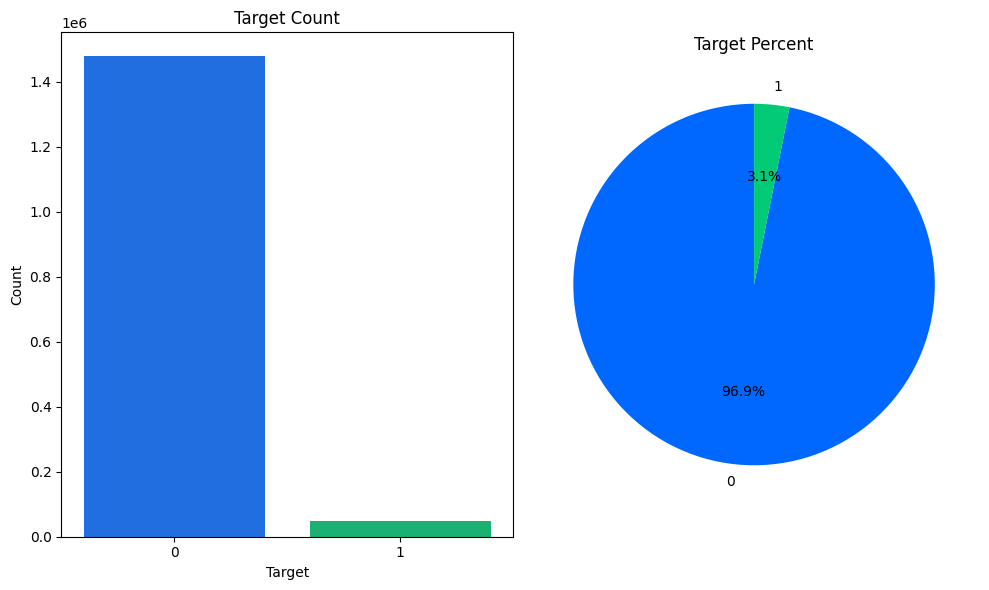

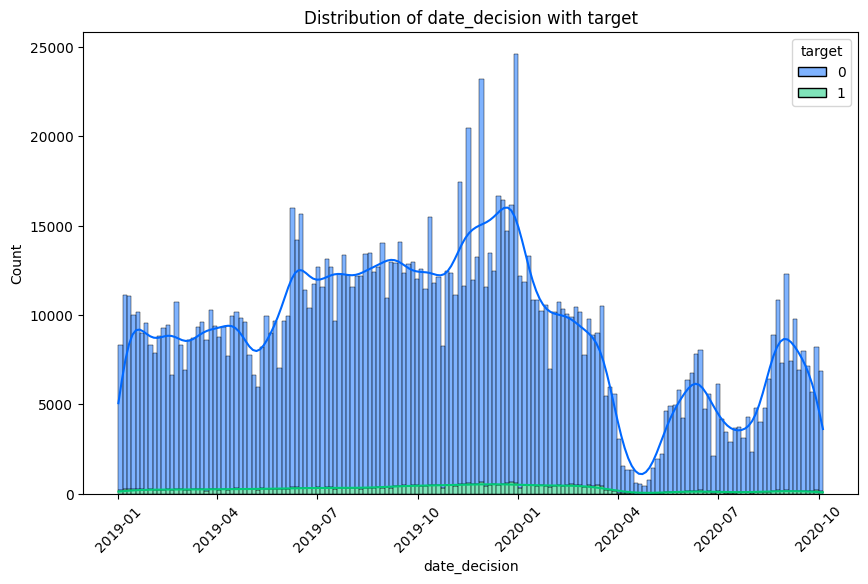

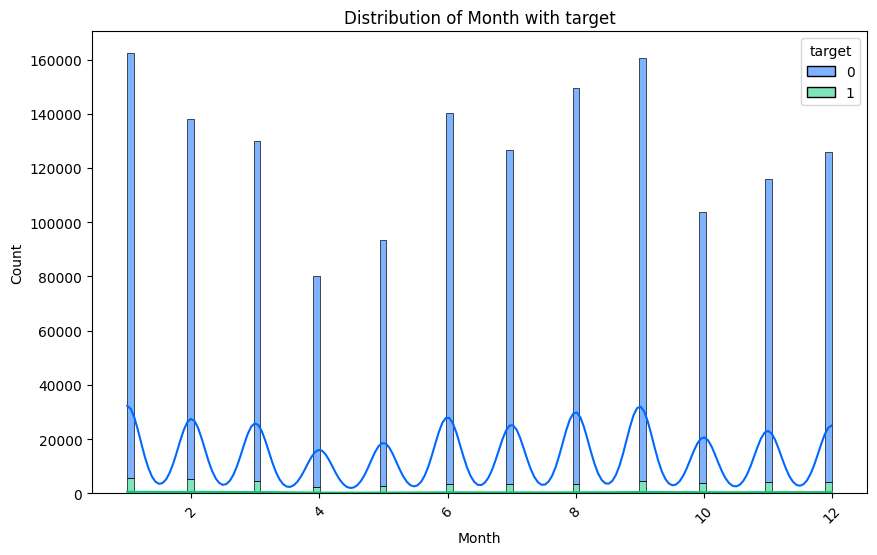

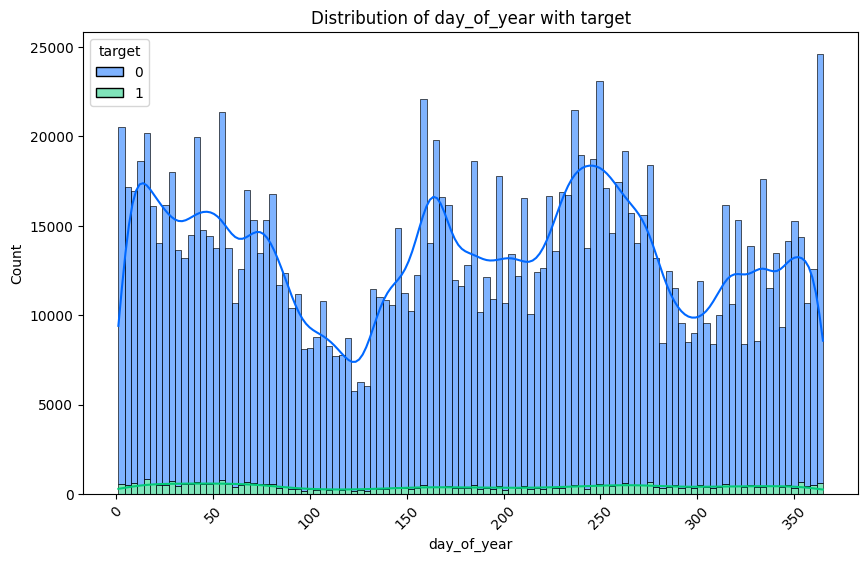

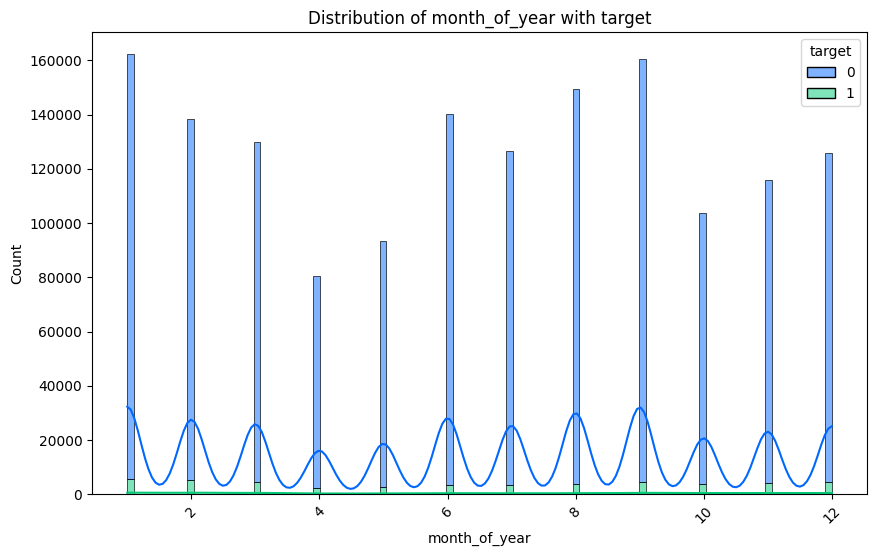

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def compare_target_distribution(df, target_col='target'):
    """
    Compare count and percent between 0 and 1 target, plot the chart.
    """
    target_counts = df[target_col].value_counts()
    target_percent = df[target_col].value_counts(normalize=True) * 100
    
    # Define consistent colors
    colors = ['#0068ff', '#03ca77']
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 6))

    # Use the same colors for the bar chart
    sns.barplot(x=target_counts.index, y=target_counts.values, ax=ax[0], palette=colors)
    ax[0].set_title('Target Count')
    ax[0].set_xlabel('Target')
    ax[0].set_ylabel('Count')

    # Use the same colors for the pie chart
    target_percent.plot.pie(ax=ax[1], autopct='%1.1f%%', startangle=90, colors=colors)
    ax[1].set_title('Target Percent')
    ax[1].set_ylabel('')

    plt.tight_layout()
    plt.show()

def plot_distribution(df, x_col, target_col='target', title=''):
    """
    Plot the distribution of x_col with target.
    """
    plt.figure(figsize=(10, 6))
    # Use the same colors for the histplot
    sns.histplot(data=df, x=x_col, hue=target_col, multiple='stack', kde=True, 
                palette=['#0068ff', '#03ca77'])
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

def plot_date_decision_distribution(df, target_col='target'):
    """
    Plot the distribution of date_decision with target.
    """
    df['date_decision'] = pd.to_datetime(df['date_decision'])
    plot_distribution(df, 'date_decision', target_col, 'Distribution of date_decision with target')

def plot_month_distribution(df, target_col='target'):
    """
    Plot the distribution of Month with target.
    """
    df['Month'] = pd.to_datetime(df['date_decision']).dt.month
    plot_distribution(df, 'Month', target_col, 'Distribution of Month with target')

def plot_day_of_year_distribution(df, target_col='target'):
    """
    Plot the distribution of day_of_year with target.
    """
    df['day_of_year'] = pd.to_datetime(df['date_decision']).dt.dayofyear
    plot_distribution(df, 'day_of_year', target_col, 'Distribution of day_of_year with target')

def plot_month_of_year_distribution(df, target_col='target'):
    """
    Plot the distribution of month_of_year with target.
    """
    df['month_of_year'] = pd.to_datetime(df['date_decision']).dt.month
    plot_distribution(df, 'month_of_year', target_col, 'Distribution of month_of_year with target')


train_base = pl.read_csv(TRAIN_BASE)
train_base_pd = train_base.to_pandas()

# Compare target distribution
compare_target_distribution(train_base_pd)

# Plot distributions
plot_date_decision_distribution(train_base_pd)
plot_month_distribution(train_base_pd)
plot_day_of_year_distribution(train_base_pd)
plot_month_of_year_distribution(train_base_pd)

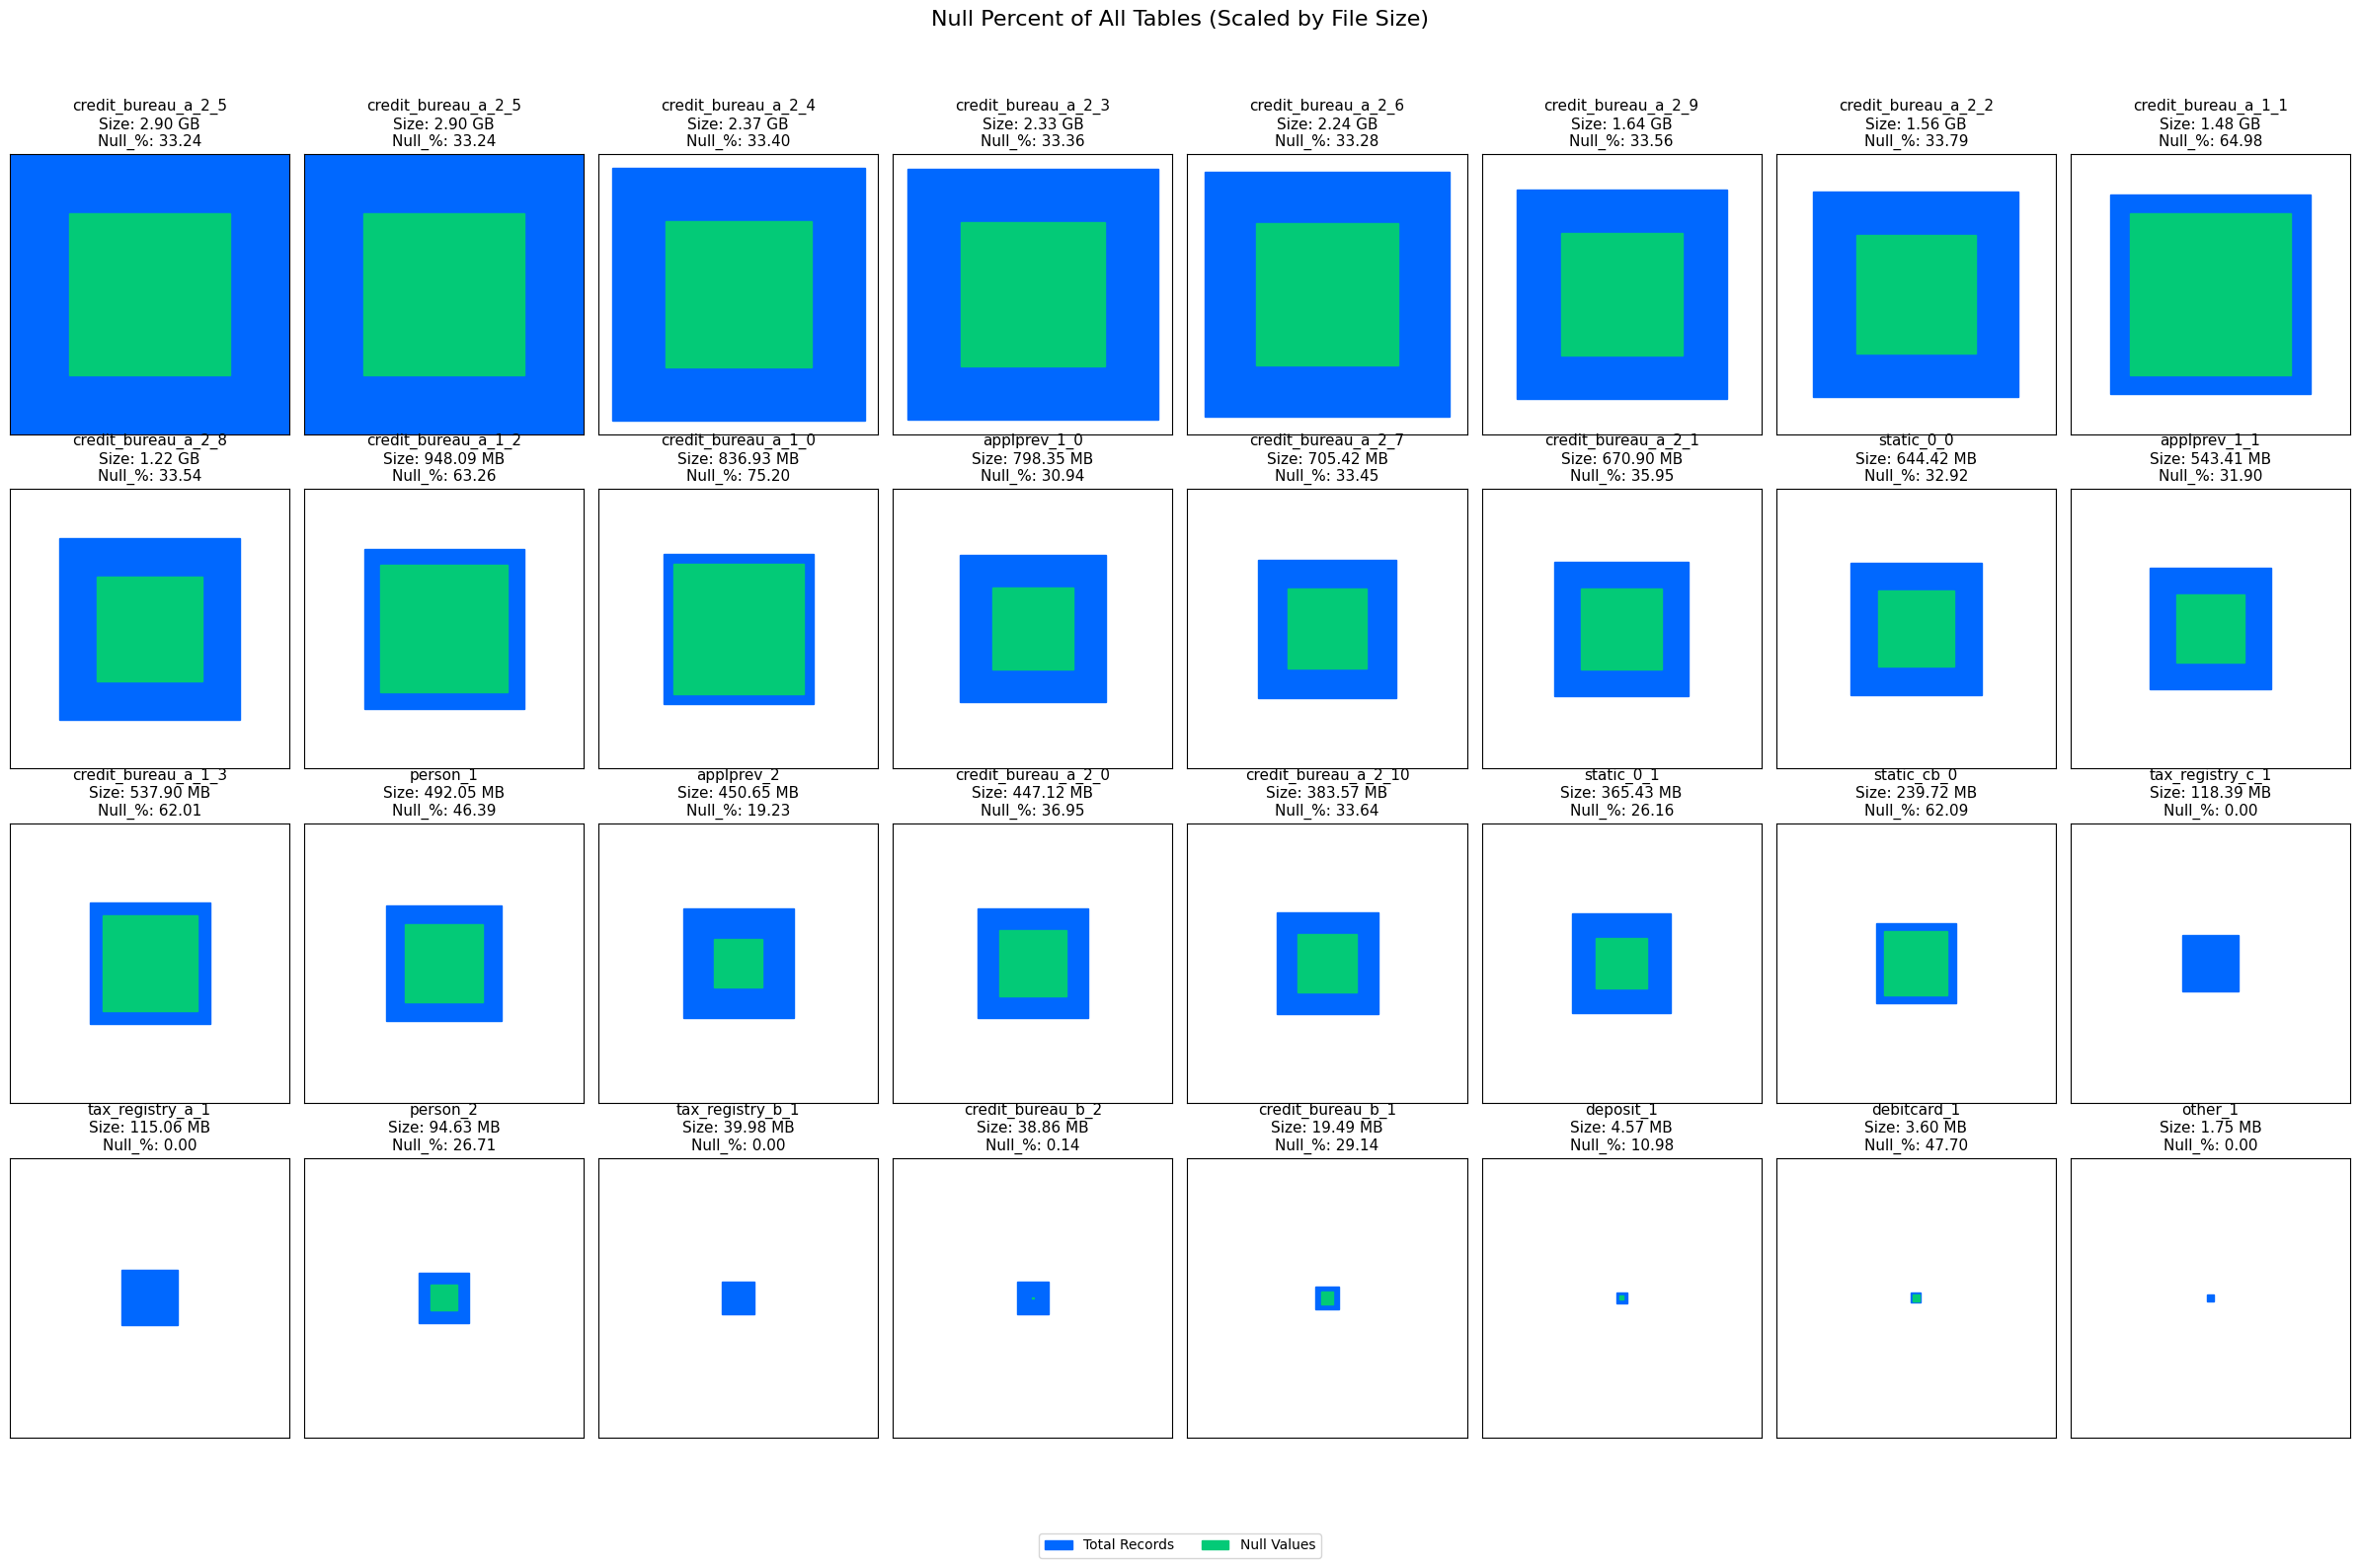

In [32]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

def get_file_size(file_path):
    """
    Get the size of the file in MB.
    """
    return os.path.getsize(file_path) / (1024 * 1024)  # Convert bytes to MB

def calculate_null_percent(df):
    """
    Calculate the null percent of each column in the DataFrame.
    """
    null_counts = df.null_count().to_pandas().iloc[0]
    total_counts = len(df)
    null_percent = (null_counts / total_counts) * 100
    return null_percent.mean()  # Calculate average null percent across all columns

def plot_null_percent_squares(table_info, title=''):
    """
    Plot squares representing null percent of each table, scaled by file size.
    """
    # Sort tables by file size in descending order
    table_info_sorted = sorted(table_info, key=lambda x: x['size'], reverse=True)
    
    tables = [info['table'] for info in table_info_sorted]
    values = [info['null_percent'] for info in table_info_sorted]
    sizes = [info['size'] for info in table_info_sorted]
    
    # Scale sizes relative to the largest file
    max_size = max(sizes)
    area_scaling = [size/max_size for size in sizes]

    num_tables = len(values)
    cols = 8  # Fixed 8 columns per row
    rows = (num_tables + cols - 1) // cols  # Calculate the number of rows needed

    fig, axs = plt.subplots(rows, cols, figsize=(24, 4 * rows))  # Adjust figure size for 8 columns
    axs = axs.reshape(rows, cols) if rows > 1 else [axs]  # Ensure axs is properly shaped

    # Iterate through rows and columns
    for row in range(rows):
        for col in range(cols):
            idx = row * cols + col
            if idx >= num_tables:
                # Hide axes for empty slots
                if rows > 1:
                    axs[row, col].axis('off')
                else:
                    axs[col].axis('off')
                continue
            
            # Get the current axis
            ax = axs[row, col] if rows > 1 else axs[col]
            
            outer_square_side = np.sqrt(area_scaling[idx])
            inner_square_side = np.sqrt(area_scaling[idx] * (values[idx] / 100))

            # Add the outer square
            ax.add_patch(plt.Rectangle((0.5 - outer_square_side / 2, 0.5 - outer_square_side / 2),
                                       outer_square_side, outer_square_side,
                                       color='#0068ff', label='Total Records'))

            # Add the inner square
            ax.add_patch(plt.Rectangle((0.5 - inner_square_side / 2, 0.5 - inner_square_side / 2),
                                       inner_square_side, inner_square_side,
                                       color='#03ca77', label='Null Values'))

            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect('equal')
            
            # Format size display based on magnitude
            if sizes[idx] >= 1000:
                size_str = f"{sizes[idx]/1000:.2f} GB"
            else:
                size_str = f"{sizes[idx]:.2f} MB"
                
            ax.set_title(f'{tables[idx]}\nSize: {size_str}\nNull_%: {values[idx]:.2f}', fontsize=11)

    # Create custom legend handles
    legend_handles = [
        plt.Rectangle((0, 0), 1, 1, color='#0068ff', label='Total Records'),
        plt.Rectangle((0, 0), 1, 1, color='#03ca77', label='Null Values')
    ]
    
    fig.legend(handles=legend_handles, labels=['Total Records', 'Null Values'], 
               loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=2)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Leave space for the legend
    plt.show()

def process_tables(tables, data_dir):
    """
    Process each table to calculate null percent and file size.
    """
    table_info = []
    for table in tables:
        try:
            file_path = data_dir / f"train_{table}.csv"
            if file_path.exists():
                file_size = get_file_size(file_path)
                df = pl.read_csv(file_path)
                null_percent = calculate_null_percent(df)
                table_info.append({
                    'table': table,
                    'null_percent': null_percent,
                    'size': file_size
                })
            else:
                print(f"File not found: {file_path}")
        except Exception as e:
            print(f"Error processing {table}: {e}")
    
    return table_info

# Directory paths
ROOT_DIR = Path(os.getcwd())
DATA_DIR = ROOT_DIR / "data" / "home-credit-credit-risk-model-stability" / "csv_files" / "train"

# Table groups by depth of train data
DEPTH_0_TABLES_TRAIN = ["static_0_0", "static_0_1", "static_cb_0"]
DEPTH_1_TABLES_TRAIN = [
    "applprev_1_0", "applprev_1_1", "other_1", "tax_registry_a_1", 
    "tax_registry_b_1", "tax_registry_c_1", "credit_bureau_a_1_0", 
    "credit_bureau_a_1_3", "credit_bureau_a_1_1", "credit_bureau_a_1_2", 
    "credit_bureau_b_1", "deposit_1", "person_1", "debitcard_1"
]
DEPTH_2_TABLES_TRAIN = [
    "applprev_2", "person_2", "credit_bureau_a_2_0", "credit_bureau_a_2_1", 
    "credit_bureau_a_2_2", "credit_bureau_a_2_3", "credit_bureau_a_2_4", 
    "credit_bureau_a_2_5", "credit_bureau_a_2_6", "credit_bureau_a_2_7", 
    "credit_bureau_a_2_8", "credit_bureau_a_2_9", "credit_bureau_a_2_10", 
    "credit_bureau_a_2_5", "credit_bureau_b_2"
]

# Combine all tables
ALL_TABLES = DEPTH_0_TABLES_TRAIN + DEPTH_1_TABLES_TRAIN + DEPTH_2_TABLES_TRAIN

# Process all tables and create one plot
table_info = process_tables(ALL_TABLES, DATA_DIR)
plot_null_percent_squares(table_info, 'Null Percent of All Tables (Scaled by File Size)')

Processing applprev_1_0...
Processing applprev_1_1...
Processing applprev_2...
Processing base...
Processing credit_bureau_a_1_0...
Processing credit_bureau_a_1_1...
Processing credit_bureau_a_1_2...
Processing credit_bureau_a_1_3...
Processing credit_bureau_a_2_0...
Processing credit_bureau_a_2_1...
Processing credit_bureau_a_2_10...
Processing credit_bureau_a_2_2...
Processing credit_bureau_a_2_3...
Processing credit_bureau_a_2_4...
Processing credit_bureau_a_2_5...
Processing credit_bureau_a_2_6...
Processing credit_bureau_a_2_7...
Processing credit_bureau_a_2_8...
Processing credit_bureau_a_2_9...
Processing credit_bureau_b_1...
Processing credit_bureau_b_2...
Processing debitcard_1...
Processing deposit_1...
Processing other_1...
Processing person_1...
Processing person_2...
Processing static_0_0...
Processing static_0_1...
Processing static_cb_0...
Processing tax_registry_a_1...
Processing tax_registry_b_1...
Processing tax_registry_c_1...
Total variables analyzed: 464

Top 20 va

C:\Users\thong\AppData\Local\Temp\ipykernel_6100\490678749.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Avg_Null_Percentage', y='Variable', data=top_df, palette='coolwarm')


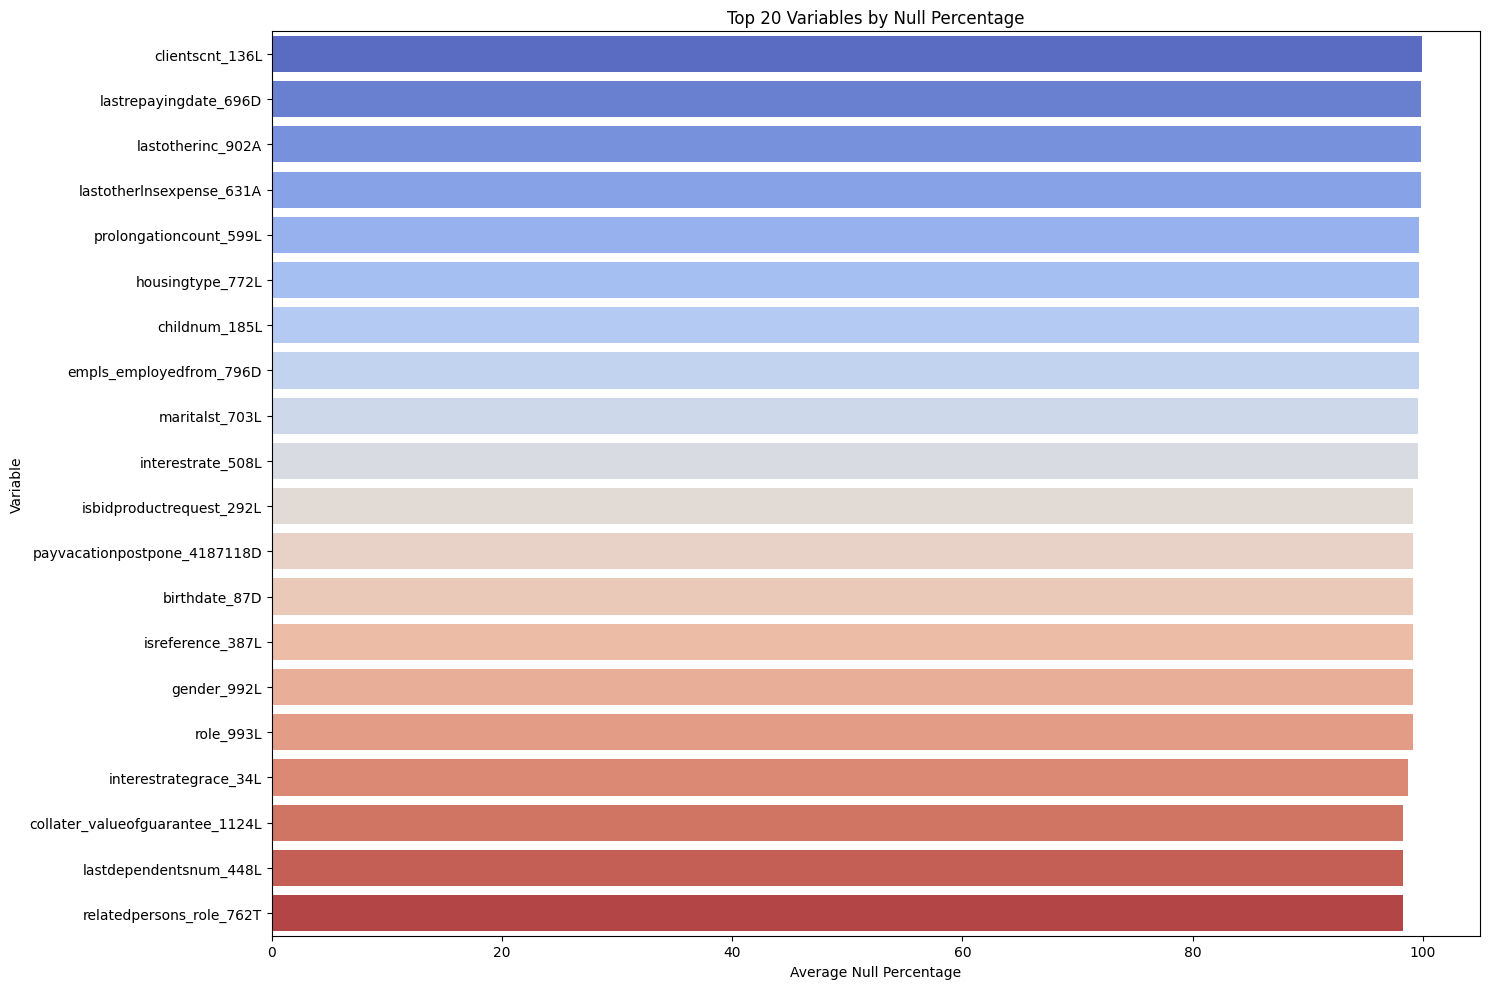

C:\Users\thong\AppData\Local\Temp\ipykernel_6100\490678749.py:214: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Table_Count', y='Variable', data=top_df, palette='viridis')


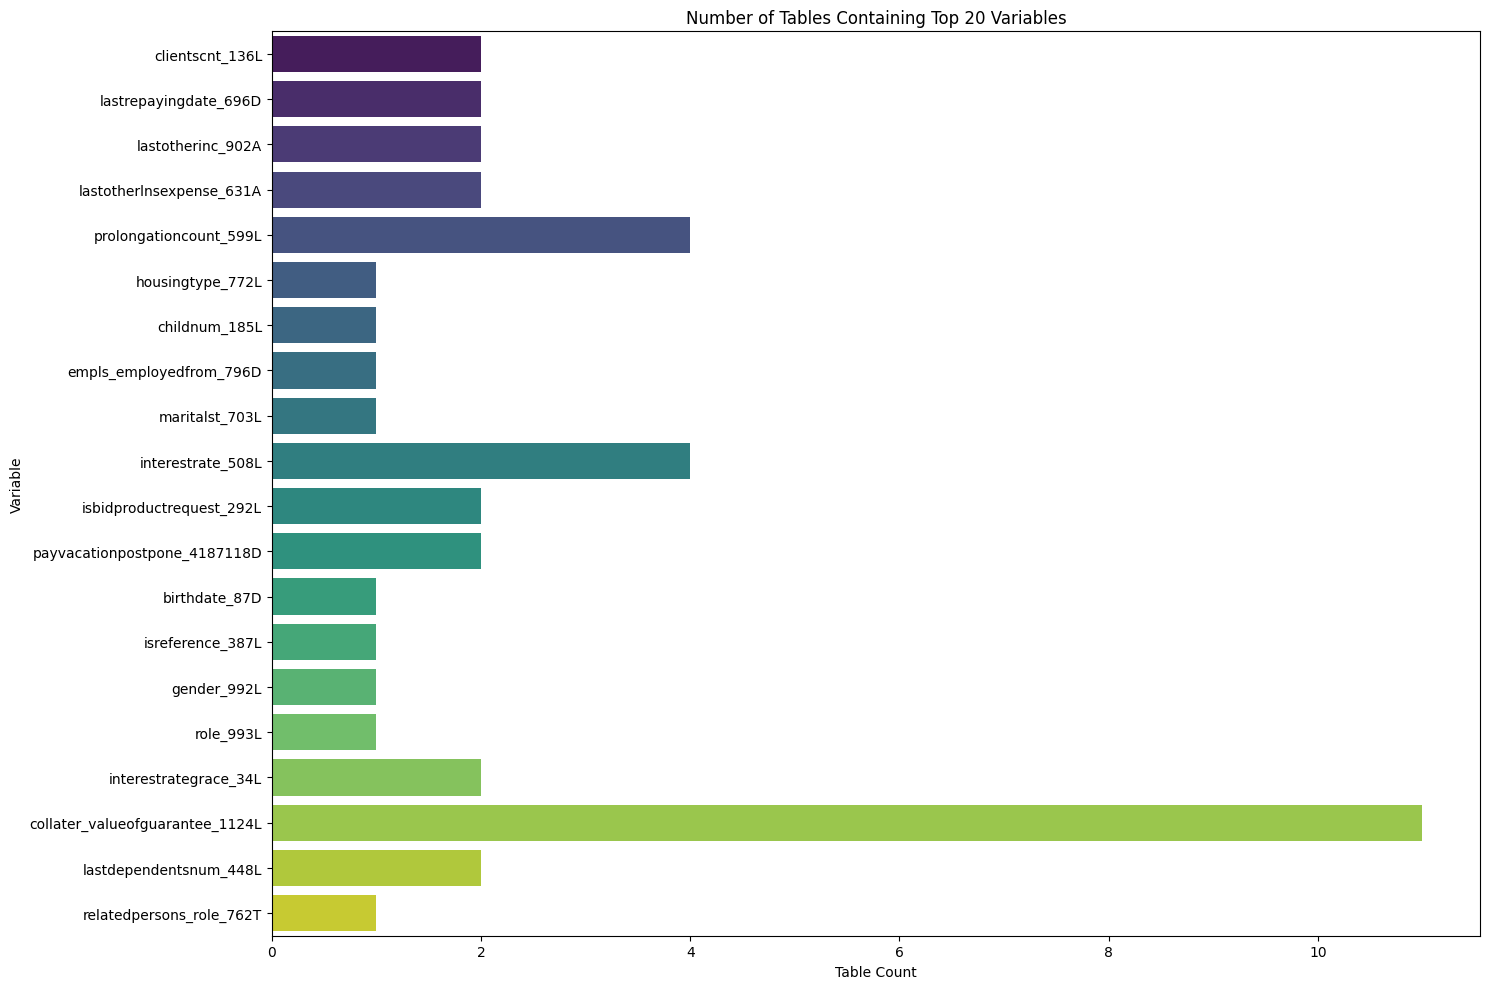

Results saved to c:\Users\thong\Desktop\Home_Credit\variable_null_percentages.csv
Similar variables analysis saved to c:\Users\thong\Desktop\Home_Credit\similar_variables_analysis.csv


In [38]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from pathlib import Path
from difflib import SequenceMatcher
import re

def similarity_score(a, b):
    """Calculate similarity between two strings"""
    return SequenceMatcher(None, a.lower(), b.lower()).ratio()

def clean_description(description):
    """Clean and standardize description text"""
    # Remove punctuation and standardize
    return re.sub(r'[^\w\s]', '', description.lower())

def analyze_null_percentage(data_dir, feature_definitions_path):
    """
    Analyze the null percentage of each variable across all tables in the training data.
    
    Parameters:
    -----------
    data_dir : str or Path
        Directory path containing the training data files
    feature_definitions_path : str or Path
        Path to the feature definitions CSV file
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with null percentage for each variable across tables
    """
    # Read feature definitions
    feature_df = pd.read_csv(feature_definitions_path)
    feature_variables = feature_df['Variable'].tolist()
    
    # Initialize results dictionary
    null_percentages = {}
    variable_found = {var: False for var in feature_variables}
    
    # Get all CSV files in the directory
    data_files = list(Path(data_dir).glob("train_*.csv"))
    
    # Process each file
    for file_path in data_files:
        table_name = file_path.stem.replace('train_', '')
        print(f"Processing {table_name}...")
        
        try:
            # Read the data file
            df = pl.read_csv(file_path)
            
            # Get column names
            columns = df.columns
            
            # Check for feature variables in this table
            for var in feature_variables:
                if var in columns:
                    # Mark variable as found
                    variable_found[var] = True
                    
                    # Calculate null percentage for this variable in this table
                    null_count = df[var].null_count()
                    total_count = len(df)
                    null_pct = (null_count / total_count) * 100
                    
                    # Store the result
                    if var not in null_percentages:
                        null_percentages[var] = {}
                    null_percentages[var][table_name] = null_pct
        
        except Exception as e:
            print(f"Error processing {table_name}: {e}")
    
    # Create results DataFrame
    results = []
    for var in feature_variables:
        if variable_found[var]:
            # Get the description for this variable
            description = feature_df[feature_df['Variable'] == var]['Description'].values[0]
            
            # Calculate average null percentage across all tables where this variable appears
            tables = list(null_percentages.get(var, {}).keys())
            null_pcts = list(null_percentages.get(var, {}).values())
            avg_null_pct = sum(null_pcts) / len(null_pcts) if null_pcts else 0
            
            results.append({
                'Variable': var,
                'Description': description,
                'Clean_Description': clean_description(description),
                'Tables': ', '.join(tables),
                'Table_Count': len(tables),
                'Avg_Null_Percentage': avg_null_pct
            })
    
    # Create DataFrame and sort by null percentage
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Avg_Null_Percentage', ascending=False)
    
    return results_df

def identify_similar_variables(results_df, similarity_threshold=0.8):
    """
    Identify variables with similar descriptions and keep the ones with the lowest null percentage.
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        DataFrame with variable information and null percentages
    similarity_threshold : float
        Threshold for considering descriptions similar (0-1)
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with variables to keep and their similar variables
    """
    # Create a copy of the dataframe sorted by null percentage (ascending)
    sorted_df = results_df.sort_values('Avg_Null_Percentage', ascending=True)
    
    # Dictionary to store variables to keep and their similar variables
    variables_to_keep = {}
    already_processed = set()
    
    # Process each variable
    for i, row1 in sorted_df.iterrows():
        var1 = row1['Variable']
        
        # Skip if this variable has already been processed
        if var1 in already_processed:
            continue
        
        desc1 = row1['Clean_Description']
        similar_vars = []
        
        # Compare with other variables
        for j, row2 in sorted_df.iterrows():
            if i == j:
                continue
            
            var2 = row2['Variable']
            if var2 in already_processed:
                continue
                
            desc2 = row2['Clean_Description']
            
            # Calculate similarity
            sim_score = similarity_score(desc1, desc2)
            
            # If similar enough
            if sim_score >= similarity_threshold:
                similar_vars.append({
                    'Variable': var2,
                    'Description': row2['Description'],
                    'Similarity': sim_score,
                    'Null_Percentage': row2['Avg_Null_Percentage']
                })
                already_processed.add(var2)
        
        # If we found similar variables, keep this one
        if similar_vars:
            variables_to_keep[var1] = {
                'Variable': var1,
                'Description': row1['Description'],
                'Null_Percentage': row1['Avg_Null_Percentage'],
                'Similar_Variables': similar_vars
            }
            already_processed.add(var1)
    
    # Convert to DataFrame
    keep_results = []
    for var, data in variables_to_keep.items():
        similar_vars_str = ", ".join([f"{v['Variable']} ({v['Null_Percentage']:.2f}%)" for v in data['Similar_Variables']])
        keep_results.append({
            'Variable_To_Keep': var,
            'Description': data['Description'],
            'Null_Percentage': data['Null_Percentage'],
            'Similar_Variables': similar_vars_str,
            'Num_Similar_Variables': len(data['Similar_Variables'])
        })
    
    keep_df = pd.DataFrame(keep_results)
    keep_df = keep_df.sort_values('Num_Similar_Variables', ascending=False)
    
    return keep_df

def plot_null_percentage_distribution(results_df, top_n=20):
    """
    Plot the distribution of null percentages for the top N variables.
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        DataFrame with null percentage results
    top_n : int
        Number of top variables to display
    """
    # Get top N variables by null percentage
    top_df = results_df.head(top_n)
    
    plt.figure(figsize=(15, 10))
    sns.barplot(x='Avg_Null_Percentage', y='Variable', data=top_df, palette='coolwarm')
    plt.title(f'Top {top_n} Variables by Null Percentage')
    plt.xlabel('Average Null Percentage')
    plt.ylabel('Variable')
    plt.tight_layout()
    plt.show()
    
    # Plot the number of tables containing each variable
    plt.figure(figsize=(15, 10))
    sns.barplot(x='Table_Count', y='Variable', data=top_df, palette='viridis')
    plt.title(f'Number of Tables Containing Top {top_n} Variables')
    plt.xlabel('Table Count')
    plt.ylabel('Variable')
    plt.tight_layout()
    plt.show()

# Usage example:
ROOT_DIR = Path(os.getcwd())
DATA_DIR = ROOT_DIR / "data" / "home-credit-credit-risk-model-stability" / "csv_files" / "train"
FEATURE_DEFINITIONS_PATH = ROOT_DIR / "data" / "home-credit-credit-risk-model-stability" / "feature_definitions.csv"

# Analyze null percentages
results_df = analyze_null_percentage(DATA_DIR, FEATURE_DEFINITIONS_PATH)

# Print summary
print(f"Total variables analyzed: {len(results_df)}")
print("\nTop 20 variables with highest null percentage:")
print(results_df[['Variable', 'Description', 'Table_Count', 'Avg_Null_Percentage']].head(20))

# Identify similar variables and keep the ones with lowest null percentage
similar_vars_df = identify_similar_variables(results_df, similarity_threshold=0.85)
print("\nVariables to keep (with similar variables):")
print(similar_vars_df)

# Plot the results
plot_null_percentage_distribution(results_df, top_n=20)

# Export results to CSV
results_df.to_csv(ROOT_DIR / "variable_null_percentages.csv", index=False)
similar_vars_df.to_csv(ROOT_DIR / "similar_variables_analysis.csv", index=False)
print(f"Results saved to {ROOT_DIR / 'variable_null_percentages.csv'}")
print(f"Similar variables analysis saved to {ROOT_DIR / 'similar_variables_analysis.csv'}")